<a href="https://colab.research.google.com/github/rrwiren/ilmanlaatu-ennuste-helsinki/blob/main/Colab_Script_SARIMAX_(v9_Selitetty_luokitteluraportti).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- SARIMAX Ozone Forecasting Script (with Weather Data - v9 - Clarified Report) ---

Ladataan ozone dataa: https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kallio%202_%201.4.2020%20-%201.4.2025_f5d0d5ac-9f7d-4833-a70b-c1afe4dc935a.csv
Datan (ozone) käsittely valmis, muoto: (43180, 1)

Ladataan weather dataa: https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kaisaniemi_%201.4.2020%20-%201.4.2025_d5590617-bf91-46c7-96f4-1fb70892265d.csv
Datan (weather) käsittely valmis, muoto: (43463, 3)

Yhdistetään otsoni- ja säädata...
Yhdistämisen jälkeen rivejä (raw): 42803
Rivejä NaN-poiston jälkeen (raw): 42803
Uudelleenotanta ('resample') tunneittaiseen taajuuteen...
Rivejä resamplen jälkeen: 43848
Löytyi 4180 NaN-arvoa resamplen jälkeen. Interpoloidaan (time)...
Datan yhdistäminen ja resample onnistui.

--- 3. Stationarisuus ja kausivaihtelu ---
Käytetään parametreja: d=0, s=24, D=1

--- 4. SARIMAX-järjes

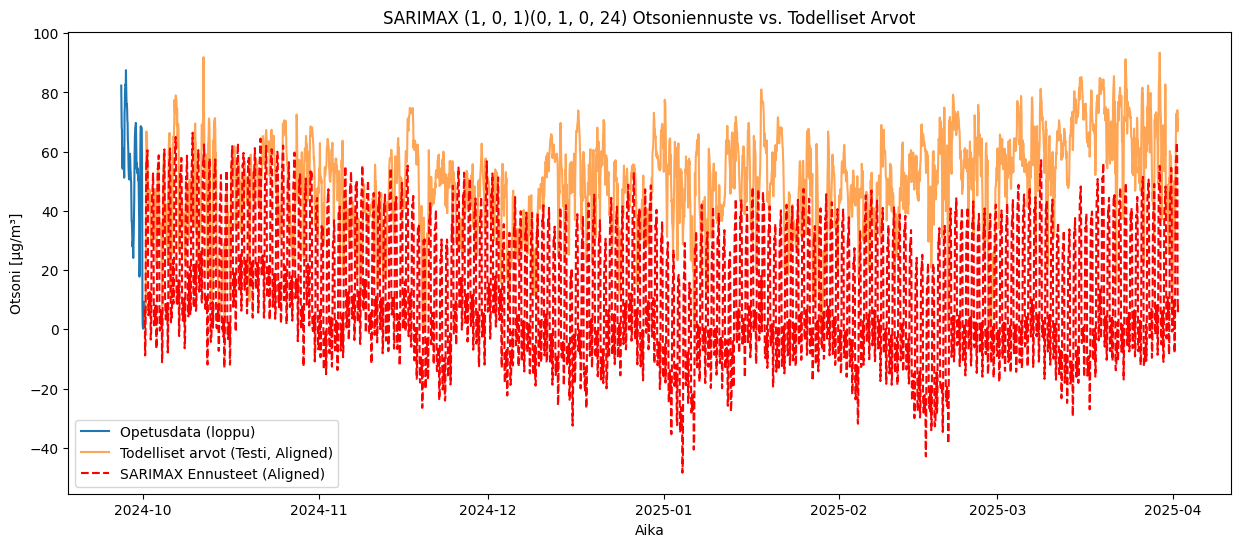


--- 9. Piikkien päätteleminen ennusteista (valinnainen) ---
Käytetään piikin kynnysarvoa (opetusdatan 90. persentiili): 77.90

SARIMAX Piikkiennusteiden (päätelty) evaluointi:
Ei voitu laskea luokitteluraporttia: Malli ennusti vain yhtä luokkaa (todennäköisesti vain 'ei-piikki').
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4280
           1       0.00      0.00      0.00       105

    accuracy                           0.98      4385
   macro avg       0.49      0.50      0.49      4385
weighted avg       0.95      0.98      0.96      4385

Confusion Matrix:
[[4280    0]
 [ 105    0]]
Todellisia piikkejä (aligned): 105
Ennustettuja piikkejä (aligned): 0

--- SARIMAX-skripti päättyi ---


In [1]:
# -*- coding: utf-8 -*-
"""
Colab Script for SARIMAX Ozone Forecasting - v9

Loads data, merges, RESAMPLES, handles NaNs, fits a SARIMAX model
with order (1,0,1)(0,1,0,24) and scaled exogenous variables,
uses predict(), and evaluates. Includes clarification comment for classification report.
"""

# Kirjastojen tuonti
import pandas as pd
import numpy as np
import io
import requests
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import traceback

# Aikasarja-analyysikirjastot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix
from math import sqrt
from sklearn.preprocessing import StandardScaler

print("--- SARIMAX Ozone Forecasting Script (with Weather Data - v9 - Clarified Report) ---")

# --- Funktiot datan lataamiseen ja peruspuhdistukseen ---
# (Sama kuin aiemmin v7/v8)
def load_and_clean_data(raw_url, data_type='weather', cols_to_keep=None):
    """Lataa ja esikäsittelee datan, pitäen vain tarvittavat sarakkeet."""
    print(f"\nLadataan {data_type} dataa: {raw_url}")
    df_local = None
    try:
        response = requests.get(raw_url)
        response.raise_for_status()
        encoding = 'utf-8' if data_type == 'weather' else 'iso-8859-1'
        # print(f"Lukeminen CSV:stä (encoding={encoding})...")
        csv_content = io.StringIO(response.content.decode(encoding))

        if data_type == 'ozone':
             column_names_ozone = ["Havaintoasema", "Vuosi", "Kuukausi", "Päivä", "Aika [Paikallinen aika]", "Otsoni [µg/m³]"]
             df_local = pd.read_csv(
                  csv_content, sep=',', decimal=',', skiprows=1, header=None,
                  names=column_names_ozone, quoting=csv.QUOTE_NONNUMERIC, low_memory=False
             )
             target_col = "Otsoni [µg/m³]"
             if target_col in df_local.columns:
                  df_local[target_col] = pd.to_numeric(df_local[target_col], errors='coerce')
             else: raise ValueError(f"Otsonisarake '{target_col}' ei löytynyt.")

        elif data_type == 'weather':
            df_local = pd.read_csv(csv_content, sep=',', decimal='.', low_memory=False)
            df_local.columns = df_local.columns.str.strip()
            weather_cols_to_convert = ['Lämpötilan keskiarvo [°C]', 'Keskituulen nopeus [m/s]', 'Tuulen suunnan keskiarvo [°]', 'Ilmanpaineen keskiarvo [hPa]']
            for col in weather_cols_to_convert:
                 if col in df_local.columns:
                      df_local[col] = pd.to_numeric(df_local[col], errors='coerce')

        else: raise ValueError(f"Tuntematon data_type: {data_type}")

        year_col, month_col, day_col, time_col = 'Vuosi', 'Kuukausi', 'Päivä', 'Aika [Paikallinen aika]'
        required_dt_cols = [year_col, month_col, day_col, time_col]
        if not all(col in df_local.columns for col in required_dt_cols):
            raise ValueError(f"Aikaleiman luontiin vaadittavia sarakkeita puuttuu: {required_dt_cols}")

        df_local[year_col] = pd.to_numeric(df_local[year_col], errors='coerce').astype('Int64')
        df_local[month_col] = pd.to_numeric(df_local[month_col], errors='coerce').astype('Int64')
        df_local[day_col] = pd.to_numeric(df_local[day_col], errors='coerce').astype('Int64')
        if df_local[required_dt_cols].isnull().any().any():
            df_local.dropna(subset=required_dt_cols, inplace=True)

        df_local[year_col] = df_local[year_col].astype(str)
        df_local[month_col] = df_local[month_col].astype(str).str.zfill(2)
        df_local[day_col] = df_local[day_col].astype(str).str.zfill(2)
        df_local[time_col] = df_local[time_col].astype(str)
        time_str = df_local[time_col].str.replace('24:00', '00:00', regex=False)
        datetime_str = df_local[year_col] + '-' + df_local[month_col] + '-' + df_local[day_col] + ' ' + time_str
        df_local['Timestamp'] = pd.to_datetime(datetime_str, format='%Y-%m-%d %H:%M', errors='coerce')
        df_local.loc[df_local[time_col] == '24:00', 'Timestamp'] += pd.Timedelta(days=1)

        cols_to_select = ['Timestamp'] + (cols_to_keep if cols_to_keep else [])
        missing_cols = [col for col in cols_to_select if col not in df_local.columns]
        if missing_cols:
             raise ValueError(f"Vaadittuja sarakkeita puuttuu datasta: {missing_cols}")
        df_local = df_local[cols_to_select].copy()

        df_local.dropna(subset=['Timestamp'] + (cols_to_keep if cols_to_keep else []), inplace=True)

        df_local.set_index('Timestamp', inplace=True)
        df_local.sort_index(inplace=True)
        duplicates = df_local.index.duplicated(keep='first')
        if duplicates.sum() > 0:
            # print(f"Poistetaan {duplicates.sum()} duplikaatti-indeksiä.")
            df_local = df_local[~duplicates]

        print(f"Datan ({data_type}) käsittely valmis, muoto: {df_local.shape}")
        if df_local.empty: print(f"VAROITUS: {data_type} DataFrame on tyhjä!")
        return df_local

    except requests.exceptions.RequestException as e:
        print(f"Virhe datan haussa URL:sta ({data_type}): {e}")
        return None
    except Exception as e:
        print(f"Virhe datan käsittelyssä ({data_type}): {e}")
        traceback.print_exc()
        return None

# --- 1. Datan lataus ---
ozone_url = "https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kallio%202_%201.4.2020%20-%201.4.2025_f5d0d5ac-9f7d-4833-a70b-c1afe4dc935a.csv"
weather_url = "https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kaisaniemi_%201.4.2020%20-%201.4.2025_d5590617-bf91-46c7-96f4-1fb70892265d.csv"

o3_col = "Otsoni [µg/m³]"
weather_cols = ['Lämpötilan keskiarvo [°C]', 'Keskituulen nopeus [m/s]', 'Ilmanpaineen keskiarvo [hPa]']

df_ozone = load_and_clean_data(ozone_url, data_type='ozone', cols_to_keep=[o3_col])
df_weather = load_and_clean_data(weather_url, data_type='weather', cols_to_keep=weather_cols)

# --- 2. Datan yhdistäminen & RESAMPLE ---
df_merged = None
if df_ozone is not None and not df_ozone.empty and df_weather is not None and not df_weather.empty:
    print("\nYhdistetään otsoni- ja säädata...")
    df_merged_raw = pd.merge(df_ozone, df_weather, left_index=True, right_index=True, how='inner')
    print(f"Yhdistämisen jälkeen rivejä (raw): {len(df_merged_raw)}")
    df_merged_raw.dropna(inplace=True)
    print(f"Rivejä NaN-poiston jälkeen (raw): {len(df_merged_raw)}")

    if not df_merged_raw.empty:
        print("Uudelleenotanta ('resample') tunneittaiseen taajuuteen...")
        df_merged = df_merged_raw.resample('h').mean()
        print(f"Rivejä resamplen jälkeen: {len(df_merged)}")
        nan_after_resample = df_merged.isnull().sum().sum()
        if nan_after_resample > 0:
            print(f"Löytyi {nan_after_resample} NaN-arvoa resamplen jälkeen. Interpoloidaan (time)...")
            df_merged.interpolate(method='time', inplace=True)
            remaining_nan = df_merged.isnull().sum().sum()
            if remaining_nan > 0:
                 print(f"Varoitus: Jäljellä {remaining_nan} NaN-arvoa interpoloinnin jälkeen. Täytetään (ffill/bfill)...")
                 df_merged.fillna(method='ffill', inplace=True)
                 df_merged.fillna(method='bfill', inplace=True)
        if df_merged.isnull().any().any():
             print("VAROITUS: NaN-arvoja jäi datan käsittelyn jälkeen! Poistetaan rivit.")
             df_merged.dropna(inplace=True)
        if df_merged.empty:
            print("Virhe: Data tyhjä resamplen/NaN-käsittelyn jälkeen.")
            df_merged = None
        else:
            print("Datan yhdistäminen ja resample onnistui.")
    else:
        print("Virhe: Yhdistetty data tyhjä ennen resamplea.")
        df_merged = None

# Jatka vain jos data ok
if df_merged is not None:

    # --- 3. Stationarisuus ja kausivaihtelu ---
    print("\n--- 3. Stationarisuus ja kausivaihtelu ---")
    # *** KÄYTETÄÄN d=0, D=1 ***
    d = 0
    s = 24
    D = 1
    print(f"Käytetään parametreja: d={d}, s={s}, D={D}")

    # --- 4. SARIMAX-järjestyksen määrittäminen ---
    print(f"\n--- 4. SARIMAX-järjestyksen määrittäminen (käytetään d={d}, D={D}, s={s}) ---")
    # *** KÄYTETÄÄN JÄRJESTYSTÄ (1,0,1)(0,1,0,24) ***
    p = 1
    q = 1 # Lisätty MA(1)
    P = 0
    Q = 0
    print(f"Käytetään SARIMAX-järjestystä: (p={p}, d={d}, q={q}) (P={P}, D={D}, Q={Q}, s={s})")
    sarimax_order = (p, d, q)
    seasonal_order = (P, D, Q, s)

    # --- 5. Datan jako opetus- ja testijoukkoihin ---
    print("\n--- 5. Datan jako opetus- ja testijoukkoihin ---")
    test_size = 0.1
    df_merged = df_merged[~df_merged.index.duplicated(keep='first')]
    split_index = int(len(df_merged) * (1 - test_size))
    df_train = df_merged.iloc[:split_index].copy()
    df_test = df_merged.iloc[split_index:].copy()
    print(f"Opetusdata: {df_train.index.min()} - {df_train.index.max()} ({len(df_train)} riviä)")
    print(f"Testidata: {df_test.index.min()} - {df_test.index.max()} ({len(df_test)} riviä)")

    endog_train = df_train[o3_col]
    exog_train = df_train[weather_cols]
    endog_test = df_test[o3_col]
    exog_test = df_test[weather_cols]

    # Skaalaa eksogeeniset muuttujat
    print("\nSkaalataan säämuuttujat (exog)...")
    scaler = StandardScaler()
    exog_train_scaled = scaler.fit_transform(exog_train)
    exog_test_scaled = scaler.transform(exog_test)
    exog_train_scaled = pd.DataFrame(exog_train_scaled, index=exog_train.index, columns=weather_cols)
    exog_test_scaled = pd.DataFrame(exog_test_scaled, index=exog_test.index, columns=weather_cols)
    print("Skaalaus valmis.")

    # --- 6. SARIMAX-mallin sovittaminen ---
    print(f"\n--- 6. SARIMAX-mallin sovittaminen opetusdataan (järjestys: {sarimax_order}{seasonal_order}) ---")
    sarimax_result = None
    try:
        sarimax_model = SARIMAX(endog_train,
                                exog=exog_train_scaled,
                                order=sarimax_order,
                                seasonal_order=seasonal_order,
                                freq='h', # Aseta taajuus 'h'
                                enforce_stationarity=False,
                                enforce_invertibility=False)
        print("Aloitetaan SARIMAX-mallin sovitus...")
        sarimax_result = sarimax_model.fit(disp=False, maxiter=100)
        print("SARIMAX-malli sovitettu.")
        # print(sarimax_result.summary())

    except Exception as e_fit:
        print(f"Virhe SARIMAX-mallin sovittamisessa: {e_fit}")
        traceback.print_exc()

    # --- 7. Ennusteiden tekeminen ---
    if sarimax_result:
        print("\n--- 7. Ennusteiden tekeminen testijaksolle (käyttäen predict) ---")
        predictions_sarimax = None
        try:
            n_train = len(df_train)
            n_total_merged = len(df_merged)
            start_pred_loc = n_train
            end_pred_loc = n_total_merged - 1

            print(f"Ennustetaan numeerisilla indekseillä: start={start_pred_loc}, end={end_pred_loc}")

            exog_test_final = exog_test_scaled.dropna()
            if len(exog_test_final) != len(exog_test_scaled):
                 print(f"VAROITUS: Poistettu rivejä exog_test_scaled:stä ennen ennustusta!")

            if len(exog_test_final) == (end_pred_loc - start_pred_loc + 1):
                 predictions_sarimax_numeric = sarimax_result.predict(start=start_pred_loc,
                                                                      end=end_pred_loc,
                                                                      exog=exog_test_final.values)
                 print("Ennusteet luotu.")
            else:
                 print(f"Virhe: Lopullisen exog_test_final pituus ({len(exog_test_final)}) ei täsmää ennustusjakson pituuteen ({end_pred_loc - start_pred_loc + 1}).")
                 predictions_sarimax_numeric = None

            if predictions_sarimax_numeric is not None:
                 if len(predictions_sarimax_numeric) == len(exog_test_final):
                      predictions_sarimax = pd.Series(predictions_sarimax_numeric, index=exog_test_final.index)
                      print("Ennusteiden indeksi muutettu aikaleimoiksi.")
                 else:
                      predictions_sarimax = None
            else:
                predictions_sarimax = None


            # --- 8. Evaluointi ---
            if predictions_sarimax is not None and not predictions_sarimax.empty:
                print("\n--- 8. Mallin evaluointi ---")
                print(f"NaNs in endog_test before alignment: {endog_test.isnull().sum()}")
                print(f"NaNs in predictions_sarimax before alignment: {predictions_sarimax.isnull().sum()}")
                comparison_df = pd.DataFrame({'actual': endog_test, 'predicted': predictions_sarimax})
                valid_comparison = comparison_df.dropna()

                if not valid_comparison.empty:
                    print(f"Evaluoidaan {len(valid_comparison)} non-NaN parilla.")
                    actual_aligned = valid_comparison['actual']
                    predicted_aligned = valid_comparison['predicted']

                    try:
                        rmse = sqrt(mean_squared_error(actual_aligned, predicted_aligned))
                        mae = mean_absolute_error(actual_aligned, predicted_aligned)
                        print(f'Test RMSE: {rmse:.3f}')
                        print(f'Test MAE: {mae:.3f}')

                        plt.figure(figsize=(15, 6))
                        plt.plot(endog_train.index[-100:], endog_train[-100:], label='Opetusdata (loppu)')
                        plt.plot(actual_aligned.index, actual_aligned, label='Todelliset arvot (Testi, Aligned)', alpha=0.7)
                        plt.plot(predicted_aligned.index, predicted_aligned, label='SARIMAX Ennusteet (Aligned)', color='red', linestyle='--')
                        plt.title(f'SARIMAX {sarimax_order}{seasonal_order} Otsoniennuste vs. Todelliset Arvot')
                        plt.xlabel('Aika')
                        plt.ylabel(o3_col)
                        plt.legend()
                        plt.show()

                        # --- 9. Piikkien päätteleminen (valinnainen) ---
                        print("\n--- 9. Piikkien päätteleminen ennusteista (valinnainen) ---")
                        try:
                            spike_threshold_train = endog_train.quantile(0.90)
                            print(f"Käytetään piikin kynnysarvoa (opetusdatan 90. persentiili): {spike_threshold_train:.2f}")
                            predicted_spikes_sarimax_bin = (predicted_aligned > spike_threshold_train).astype(int)
                            actual_spikes_test_bin = (actual_aligned > spike_threshold_train).astype(int)

                            print("\nSARIMAX Piikkiennusteiden (päätelty) evaluointi:")
                            # Tarkista luokat alignatuista binäärisistä arvoista
                            if len(np.unique(actual_spikes_test_bin)) > 1:
                                 # *** LISÄTTY KOMMENTTI TÄHÄN ***
                                 if len(np.unique(predicted_spikes_sarimax_bin)) <= 1:
                                      print("Ei voitu laskea luokitteluraporttia: Malli ennusti vain yhtä luokkaa (todennäköisesti vain 'ei-piikki').")
                                      # Luokitteluraportti vaatii ennusteita molemmista luokista (0 ja 1).
                                 print(classification_report(actual_spikes_test_bin, predicted_spikes_sarimax_bin, zero_division=0))
                                 print("Confusion Matrix:")
                                 print(confusion_matrix(actual_spikes_test_bin, predicted_spikes_sarimax_bin))
                            else:
                                 print("Ei voitu laskea luokitteluraporttia (alignatussa testidatassa ei ollut molempia luokkia).")
                            print(f"Todellisia piikkejä (aligned): {actual_spikes_test_bin.sum()}")
                            print(f"Ennustettuja piikkejä (aligned): {predicted_spikes_sarimax_bin.sum()}")
                        except Exception as e_spike:
                            print(f"Virhe piikkien päättelemisessä: {e_spike}")

                    except Exception as e_eval:
                        print(f"Virhe evaluoinnissa: {e_eval}")
                else:
                    print("Evaluointia ei voida tehdä: Ei validia dataa NaN-poiston jälkeen.")
            else:
                 print("\nEvaluointia ei voida tehdä, koska ennusteita ei luotu tai ne olivat tyhjiä.")

        except Exception as e_pred:
            print(f"Virhe ennusteiden tekemisessä: {e_pred}")
            traceback.print_exc()

    else: # sarimax_result is None
        print("\nEi voitu tehdä ennusteita, koska mallin sovitus epäonnistui.")

else: # df_merged is None or empty
    print("\nEi voitu jatkaa mallinnukseen, koska datan yhdistäminen epäonnistui tai data on tyhjä.")


print("\n--- SARIMAX-skripti päättyi ---")